In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az

## Model Comparison

To perform a Bayesian analysis we need to define a model (a combination of prior and likelihood) and then apply Bayes theorem. In a magical world we should be able to the define the *true* model corresponding to the *true* data generation process. In the real world, we can only hope to define a reasonable enough model to make predictions and/or explain the data. The process of finding this useful model is generally iterative and involves creating more than one candidate model. 

When faced with more than one model for the same data is *natural* to ask how these models compare to each other. One way to do this is to perform posterior predictive checks as we saw in the previous chapter. Another one is to evaluate the accuracy of the predictions on new data, *i.e.* data not used to fit the model in the first place. It is generally assumed that both datasets come from the *the true generating process*. 

The inconvenience of using new data, is that in general we can not afford the luxury of putting aside a portion of our data and not use it to fit a model. Even in a *big-data regime* we have good reasons to use all the available data, two of them are:

* Reduce the uncertainty of our estimates
* Increase the number of questions we can ask the data. 

For this reason a number of strategies have been develop in order to evaluate the accuracy o predictions using just the same data used to fit the model, as we will see next.

##  Predictive accuracy

Ideally, any measure of predictive accuracy should take into account the application at hand and it should include benefits and cost of the model's predictions. We discus such an example in the "chapter XXX Decision-theory". In this chapter we will, instead, discuss very general methods that are applicable to a wide range of models and problems.

A pretty common way of measuring how well a model fits the data is to compute the quadratic mean error between a data-point ($y_i$) and a poitwise prediction $\operatorname{E} (y_i \mid \theta))$:

$$\frac{1}{n} \sum_{i=1}^{n}  (y_i - \operatorname{E} (y_i \mid \theta))^2$$


This is the average of the quadratic differences between observed and predicted data. By taking the square we ensure that (positive and negative) errors do not cancel out. Also by taking the square we penalize higher larger deviations, compared to using for example the absolute value of the differences 


When doing probabilistic forecasting measures of predictive accuracy are generally known as [scoring rules](https://en.wikipedia.org/wiki/Scoring_rule). Given a probability vector $\mathbf{r}$ with a probability for each of the $i$ outcomes. A scoring rule will give a reward of $S({\mathbf {r}}, i)$ if the $i$th event occurs. We say we have a proper scoring rule, if the highest expected reward is obtained by reporting the true probability distribution. A proper scoring rule is said to be local if its value depends only on the probability $r_{i}$.  It can be [shown](https://www.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf) that the logarithmic scoring rule is the only local and proper scoring rule. This is true up to an affine transformation, that is if $S(\mathbf {r} ,i)$ is a strictly proper scoring rule then $a+b S({\mathbf {r}},i)$ with $b>0$ is also a strictly proper scoring rule. Long story short, it is pretty common to use the log-likelihood $\log p(y_i \mid \theta)$ as a measure of the point-wise predictive accuracy.

When the likelihood is Gaussian, then the average log-likelihood will be proportional to the quadratic mean error. For historical reasons people use the *deviance* scale when talking about predictive accuracy, this is simply multiplying the log-likelihood by $-2$:

$$-2\ \sum_{i=1}^{n} \log \ p(y_i \mid \theta)$$

The *deviance* is used in both Bayesians and non-Bayesians context, in the later $\theta$ is a probability distribution and in the former a point-estimate.


> The lower the deviance, the larger the log-likelihood and thus the greater the agreement between model's predictions and data. We want smaller values of deviance.

In principle the more complex a model (the more parameters to tune) the higher the deviance will be. This is reflecting the intuition that a model with more parameters will be in general more flexible and thus it will fit the data better. Thus relying only in the deviance could lead us to choose models prone to [overfitting](https://en.wikipedia.org/wiki/Overfitting). Over-fitting is the tendency of a model to adjust so well to the data used to fit it that it will be very bad at fitting (or generalizing) to new data. For this reason the deviance is used together with a term penalizing the over-complexity of models.

### Akaike Information Criterion  

This is probably the most well known IC, specially for non-Bayesians and is defined as the sum of two terms:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 p_{AIC} $$


The $\log p(y_i \mid \hat{\theta}_{mle})$, measures how well the model fits the data and the penalization term $p_{AIC}$. Here $\hat{\theta}_{mle}$ is the [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of $\theta$ and $ p_{AIC}$ is just the number of parameters in the model. 

AIC performs well in non-bayesian settings, but is not well equipped to deal with the generality of Bayesian models. It does not use the full *a posteriori* distribution, discarding potentially useful information. On average AIC will behave worst as we increase the information in the priors, or in general the structure in our model. Thus it is not compatible with informative and weakly informative priors, neither with hierarchical models. AIC assumes that the posterior can be well represented (at least asymptotically) by a Gaussian distribution, but this is not true for a number of models, including hierarchical models, mixture models, neural networks, etc. Fortunately, we have better alternatives.

## Widely available information criterion 

WAIC, generally pronounced as W-A-I-C, even when something like *wæɪk* is less of a mouthful ;-) can be regarded as a fully Bayesian extension of AIC. It also has two terms, although computed in a different way, being the most important difference that the terms are computed using the full posterior distribution, including the *effective* number of parameters. For details on the computation of WAIC please read the WAIC in depth section.


## Pareto smoothed importance sampling leave-one-out cross validation

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (CV) is another method of estimating out-of-sample prediction accuracy. This method requires re-fitting a model many times, each time excluding a portion of the data, the excluded portion is then used to measure the accuracy of them model. This process is repeated many times and the estimated accuracy of the model will be the average of each run. Then the entire data is used to fit the model one more time and this is the model used for further analysis and/or predictions. Leave-one-out cross-validation (LOO-CV) is a particular type of cross-validation when the data excluded is a single data-point. 

As CV can be quite time consuming (specially for Bayesian models) it is interesting to note that in theory it is possible to approximate LOO-CV. A practical and computational efficient way to do it requieres using a combination or strategies that includes was is call [Pareto smoothed importance sampling](https://arxiv.org/abs/1507.02646). The resulting method is known as PSIS-LOO-CV, while very useful, has a very complicated name, thus we just call it LOO. 


While LOO and WAIC approximate two different quantities, asymptotically they converge to the same numerical value, and also in practice they generally agree. The main advantage of LOO is that it is more informative as it provides [useful diagnostics](https://arxiv.org/abs/1507.04544) and other goodies such as effective sample size and Monte Carlo standard error estimates.

Using ArviZ, both LOO and WAIC can be computed just by calling a function. Let's try on an arbitrary pre-loaded model:

In [2]:
# change this to some good example
model0 = az.load_arviz_data('regression1d')
model1 = az.load_arviz_data('regression1d')

In [3]:
az.waic(model0)

Computed from 2000 by 100 log-likelihood matrix

        Estimate       SE
IC_waic   291.70    11.42
p_waic      2.73        -

In [4]:
az.loo(model0)

Computed from 2000 by 100 log-likelihood matrix

       Estimate       SE
IC_loo   291.71    11.42
p_loo      2.73        -

As you can see both WAIC and LOO return similar values. ArviZ comes equipped with `compare(.)` function. That is more convenient than using `loo(.)` or `waic(.)` 

In [5]:
az.loo(model0)

Computed from 2000 by 100 log-likelihood matrix

       Estimate       SE
IC_loo   291.71    11.42
p_loo      2.73        -

## The compare function

This function takes a dictionary of name (keys) models (values) as input and returns a DataFrame ordered (row-wise) from best to worst model.

In [6]:
cmp = az.compare({"m0":model0, "m1":model1,})
cmp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m0,0,291.702,2.72889,0,0.5,11.7583,0,False,deviance
m1,1,291.702,2.72889,0,0.5,11.7583,0,False,deviance


We have many columns, so let check one by one their meaning:

0) The index are the names of the models taken from the keys of the dictionary passed to `compare(.)`.

1) The first column has the ranking on the models starting from 0 (best model) to the number of models.

2) The second column contains the values of WAIC/LOO. The DataFrame is always sorted from best WAIC/LOO to worst. 

2) The third column has the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

3) The third column has the relative difference between the value of WAIC/LOO for the top-ranked model and the value of WAIC/LOO for each model. For this reason we will always get a value of 0 for the first model.

4) The fourth column has the weights assigned to each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. See model averaging section for more details.

5) The fifth column records the standard error for the WAIC/LOO computations. The standard error can be useful to assess the uncertainty of the WAIC/LOO estimates. By default this errors are computed using bootstrapping.

6) In sixth column we have the standard error of the differences between two values of WAIC/LOO. The same way that we can compute the standard error for each value of WAIC/LOO, we can compute the standard error of the differences between two values of WAIC/LOO. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about WAIC/LOO is correlated between models. This quantity is always 0 for the top-ranked model.

7) The fifth column records if we got *warnings* when computing WAIC/LOO, the possible values can be `True` or `False`. If `True` the computation of WAIC/LOO may not be reliable, this warning for WAIC is based on an empirical determined cutoff value and need to be interpreted with caution. The warning for value has better empirical and theoretical support.

7) Finally we have the last column named *scale*. The default is the deviance scale as previously mentioned this is obtained by multiplying the log-score by -2. Other options are `log`, this is the log-score multiplied by 1 (this reverts the order a higher WAIC/LOO will be better) and `negative-log`, this is the log-score multiplied by 1, as with the `deviance` scale a lower value is better.

## The plot_compare function

ArviZ also provides aanother convenience function that takes the output of `compare(.)` and produces a summary plot in the style of the one used in the book Statistical Rethinking by Richard McElreath.

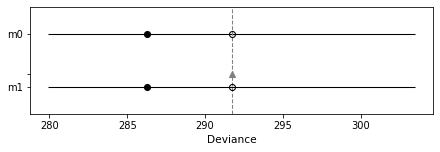

In [7]:
az.plot_compare(cmp);

The empty circle represents the values of WAIC/LOO and the black error bars associated with them are the values of the standard deviation of WAIC/LOO.

The value of the best WAIC/LOO is also indicated with a vertical dashed grey line to ease comparison with other WAIC/LOO values.

The filled black dots are the in-sample deviance of each model, i.e. the log-score without the penalty term.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errorbar indicating the standard error of the differences between the top-ranked WAIC/LOO and WAIC/LOO for each model.

## Point-wise model comparison

Comparing models is a good way to get a better understanding about them... 

## Bayes factors

Bayes factors are a common alternative to information criteria. In fact this are a diving line between to wide group of Bayesian, those who use Bayes Factors and those who dislike them.

To understand Bayes factors let us begin by writing Bayes theorem in a way that explicitly shows that our inference are always model dependent.

$$p(\theta \mid y, M_k) = {\frac {p(y \mid \theta, M_k)p(\theta \mid M_k)}{p(y \mid M_k)}}$$

Where, $y$ represents the data and $M$ the model:

The term in the denominator is known as marginal likelihood (or evidence). When doing inference we do not need to compute this normalizing constant, so in practice we often compute the posterior up to a constant factor. However, for model comparison and model averaging the marginal likelihood becomes a relevant quantity. If our main objective is to choose only one model, the best one, from a set of $k$ models we can just choose the one with the largest $p(y \mid M_k)$. As a general rule $p(y \mid M_k)$ are tiny number and does not tell us too much on its own; like with information criteria, what matters are the relative values. So in practice people often compute the ratio of two marginal likelihoods, and this is call a Bayes factor:


$$BF = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

Then when BF > 1, model 0 explains data better than model 1.

Some authors have proposed tables with ranges to discretize and ease BF interpretation. The following table indicates the strength of the evidence favoring model 0 against model 1:

* 1-3: anecdotal
* 3-10: moderate
* 10-30: strong
* 30-100: very strong
* \> 100: extreme

Remember, these rules are just conventions, simple guides at best. But results should
always be put into context and should be accompanied with enough detail so 
other could potentially check if they agree with our conclusions. The evidence
necessary to make a claim is not the same in particle physics, a court, or to
evacuate a town to prevent hundreds of deaths.

Using $p(y \mid M_k)$ to compare model is totally fine if all models are assumed to have the same prior probability[<sup>1</sup>](#fn1). Otherwise, we have to compute the *posterior odds*:

$$\underbrace{\frac{p(M_0 \mid y)}{p(M_1 \mid y)}}_\text{posterior odds} = \underbrace{\frac{p(y \mid M_0)}{p(y \mid M_1)}}_\text{Bayes factors} \, \underbrace{\frac{p(\ M_0 \ )}{p(\ M_1 \ )}}_\text{prior odds}$$

<span id="fn1"> <sup>1</sup> Notice that we are taking about the prior probability we assign to models and not about the priors we assign to parameters for each model</span>


## All that glitters is not gold

Now we will briefly discuss some key facts about the marginal likelihood. By carefully inspecting the definition of marginal likelihood we can understand their properties and consequences for their practical use:

$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$


* The good: Models with more parameters have a larger penalization than models with fewer parameters. Bayes factor has a built-in Occam Razor! The intuitive reason is that the larger the number of parameters the more spread the prior with respect to the likelihood. Thus when computing the above integral you will get a smaller value than with a more concentrated prior.  

* The bad: Computing the marginal likelihood is, generally, a hard task because the above it's an integral of a highly variable function over a high dimensional parameter space. In general this integral needs to be solved numerically using more or less sophisticated methods (see and example [here](https://docs.pymc.io/notebooks/Bayes_factor.html)).


* The ugly: The marginal likelihood depends *sensitively* on the values of the priors

Using the marginal likelihood to compare models is a good idea because a penalization for complex models is already included (thus preventing us from overfitting). At the same time, a change in the prior will affect the computations of the marginal likelihood. At first this sounds a little bit silly we already know that priors affect computations (otherwise we could simply avoid them), but the point here is the word sensitively. We are talking about changes in the prior that will keep inference of $\theta$ more or less the same, but could have a big impact in the value of the marginal likelihood. You may have noticed in previous examples that, in general,  having a normal prior with a standard deviation of 100 is the same as having one with a standard deviation of 1,000, Instead, Bayes factors will be affected by these kind of changes.

Another source of criticism to Bayes factors is that they can be used as a Bayesian way of doing hypothesis testing; there is  nothing wrong in this *per se*, but many authors have pointed out that an inference approach, similar to the one used in this book, is better suited to  most problems than the generally taught approach of hypothesis testing (whether  Bayesian or not Bayesian).

## Bayes Factors vs Information Criteria

WAIC/LOO uses the log-likelihood and the priors are not directly part of the computations, they are indirectly included because they will have an effect on the values of the models parameters. Instead, Bayes factor use priors directly as we need to average the likelihood over the prior. Conceptually we can say that Bayes factor are focused on identifying the best model (and the prior is part of the model) while WAIC and LOO are focused on which parameters will give the better predictions. As in most scenarios priors are used for their regularizing properties and when possible to provide some background-knowledge more than because we *really really believe* they reflect some *truth*, we think information criteria are a more robust approach in practice, also their computation is far less problematic and in generally is more robust without the need of using special samplers or methods.

## Model Averaging

Sometimes when comparing models, we do not want to select *the best* model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC/LOO (i.e. the uncertainty is ignored).
Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC/LOO (i.e. the uncertainty is ignored).

In [ ]:
#pp_weighted_samples = pm.sample_posterior_predictive_w(traces, weights=cmp.weight)
# do a plot comparing best model predictions vs pp_weighted_samples